In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/drug-compounds/moses.csv
/kaggle/input/drug-compounds/chembl.csv
/kaggle/input/drug-compounds/dataset_cleansed.smi
/kaggle/input/drug-compounds/known_TRPM8-inhibitors.smi
/kaggle/input/drug-compounds/TRPM8_inhibitors_for_fine-tune.smi
/kaggle/input/drug-compounds/hiv_inhibitors_cleaned.smi
/kaggle/input/drug-compounds/manual_testing_cleaned.smi


* Install the RDKit library for drug discovery from the conda-forge channel
* Note: RDKit is a powerful toolkit for cheminformatics and drug discovery.

In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 10.6 MB/s eta 0:00:0000:0100:01


In [ ]:
import copy
import numpy as np
import time

class SmilesTokenizer(object):
    def __init__(self):
        # List of atoms, special characters, and padding used in drug SMILES notation
        atoms = [
            'Li', 'Na', 'Al', 'Si', 'Cl', 'Sc', 'Zn', 'As', 'Se', 'Br', 'Sn', 'Te',
            'Cn', 'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'K', 'V', 'I',
        ]
        special = [
            '(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5', '6',
            '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's'
        ]
        padding = ['G', 'A', 'E']

        # Combine atoms, special characters, and padding to create the tokenization table
        self.table = sorted(atoms, key=len, reverse=True) + special + padding
        self.table_len = len(self.table)

        # Create a dictionary for one-hot encoding of each symbol in the table
        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(self.table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

    def tokenize(self, smiles):
        # Tokenize a SMILES string using the predefined table
        N = len(smiles)
        i = 0
        token = []

        timeout = time.time() + 5   # 5 seconds from now
        while (i < N):
            for j in range(self.table_len):
                symbol = self.table[j]
                if symbol == smiles[i:i + len(symbol)]:
                    token.append(symbol)
                    i += len(symbol)
                    break
            if time.time() > timeout:
                break
        return token

    def one_hot_encode(self, tokenized_smiles):
        # One-hot encode a tokenized SMILES string using the predefined one-hot dictionary
        result = np.array(
            [self.one_hot_dict[symbol] for symbol in tokenized_smiles],
            dtype=np.float32)
        result = result.reshape(1, result.shape[0], result.shape[1])
        return result

## RDLogger

* Disable RDKit logger to suppress unnecessary log messages
* Note: This is done to enhance clarity and reduce verbosity during drug discovery-related computations.

In [ ]:
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

In [ ]:
# Import pandas library for data manipulation and analysis
# Note: Pandas is a powerful library commonly used in drug discovery for handling and analyzing structured data.
import pandas as pd

In [ ]:
# Load SMILES data from a CSV file into a pandas DataFrame
# Note: The data is assumed to be in a file named 'moses.csv' located in the '../input/drug-compounds/' directory.
moses_smiles = pd.read_csv('../input/drug-compounds/moses.csv', sep=',')

# Display the shape of the DataFrame before removing rows with missing SMILES
print("Original Shape:", moses_smiles.shape)

# Remove rows with missing SMILES to ensure data integrity
moses_smiles = moses_smiles[moses_smiles['SMILES'].notnull()]

# Display the shape of the DataFrame after removing rows with missing SMILES
print("Shape after Removing Missing SMILES:", moses_smiles.shape)

# Create additional columns for convenience, such as 'smiles' and 'length'
moses_smiles['smiles'] = moses_smiles["SMILES"]
moses_smiles['length'] = moses_smiles["smiles"].str.len()

# Display the first few rows of the processed DataFrame
moses_smiles.head()

Original Shape: (1584663, 2)
Shape after Removing Missing SMILES: (1584663, 2)


,SMILES,SPLIT,smiles,length
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,38
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,36
2,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,35
3,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,32
4,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,30


In [ ]:
moses_smiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584663 entries, 0 to 1584662
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   SMILES  1584663 non-null  object
 1   SPLIT   1584663 non-null  object
 2   smiles  1584663 non-null  object
 3   length  1584663 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 48.4+ MB


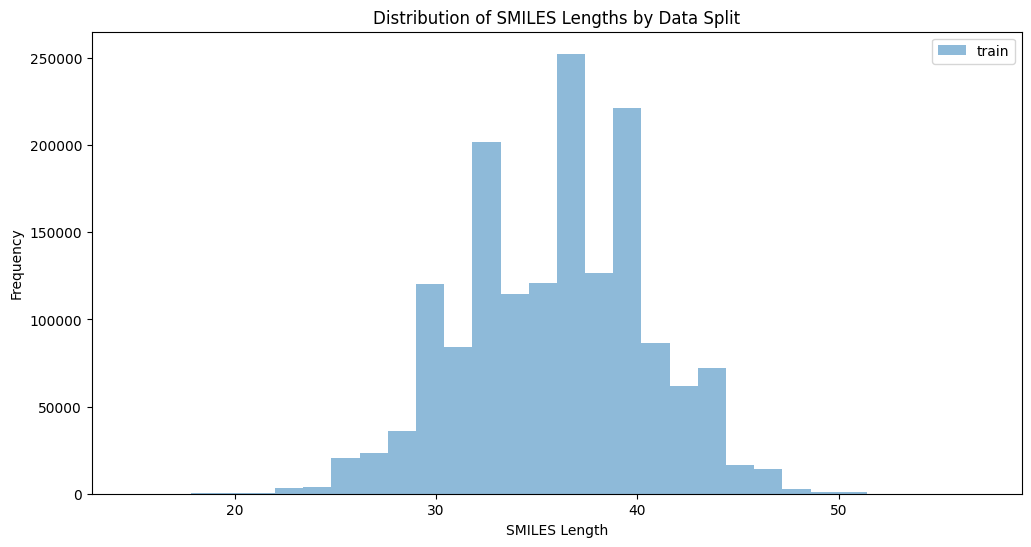

In [ ]:
import matplotlib.pyplot as plt

# Visualize the distribution of SMILES lengths across different data splits
# Note: SMILES is a notation used to represent chemical structures, and its length can be an important characteristic.

plt.figure(figsize=(12, 6))

# Iterate over unique data splits to create histograms for each split
for split in moses_smiles['SPLIT'].unique():
    subset = moses_smiles[moses_smiles['SPLIT'] == split]

    # Plot histogram for SMILES lengths with transparency and label for each split
    plt.hist(subset['length'], bins=30, alpha=0.5, label=split)

# Set plot attributes and labels
plt.title('Distribution of SMILES Lengths by Data Split')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')

# Add legend to distinguish between different data splits
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Load chemical compound SMILES data from the ChemBL dataset into a DataFrame
# Note: ChemBL is a large database of bioactive molecules with drug-like properties.

chembl_smiles = pd.read_csv('../input/drug-compounds/chembl.csv', sep=';')

# Display the shape of the DataFrame before removing rows with missing SMILES
print("Original Shape:", chembl_smiles.shape)

# Remove rows with missing SMILES to ensure data integrity
chembl_smiles = chembl_smiles[chembl_smiles['Smiles'].notnull()]

# Display the shape of the DataFrame after removing rows with missing SMILES
print("Shape after Removing Missing SMILES:", chembl_smiles.shape)

# Create additional columns for convenience, such as 'smiles' and 'length'
chembl_smiles['smiles'] = chembl_smiles["Smiles"]
chembl_smiles['length'] = chembl_smiles["smiles"].str.len()

# Display the first few rows of the processed DataFrame
chembl_smiles.head()

Original Shape: (1961462, 31)
Shape after Removing Missing SMILES: (1941410, 31)


,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,smiles,length
20,CHEMBL3457063,NaN,NaN,Small molecule,0,262.31,2.0,2.0,1.71,63.30,...,19.0,6.0,1.0,0.0,262.1430,NEUTRAL,C13H18N4O2,CC(Cn1ccnc1)NC(=O)N(C)Cc1ccco1,CC(Cn1ccnc1)NC(=O)N(C)Cc1ccco1,30
25,CHEMBL2358952,NaN,NaN,Small molecule,0,409.51,1.0,1.0,3.52,63.69,...,29.0,6.0,1.0,0.0,409.1460,NEUTRAL,C22H23N3O3S,COc1ccccc1C1CN(CCNC(=O)c2cscn2)Cc2ccccc2O1,COc1ccccc1C1CN(CCNC(=O)c2cscn2)Cc2ccccc2O1,42
29,CHEMBL4063032,NaN,NaN,Small molecule,0,323.38,1.0,3.0,3.43,59.39,...,23.0,5.0,1.0,0.0,323.0728,NEUTRAL,C17H13N3O2S,COc1ccc(-c2cnn3c(=O)c(-c4ccsc4)c[nH]c23)cc1,COc1ccc(-c2cnn3c(=O)c(-c4ccsc4)c[nH]c23)cc1,43
33,CHEMBL4217251,NaN,NaN,Unknown,0,2120.17,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2118.8906,NaN,C93H130N20O37,CC(C)C[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC...,CC(C)C[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC...,361
36,CHEMBL1914982,NaN,NaN,Small molecule,0,501.99,61.0,182.0,4.37,114.45,...,34.0,8.0,3.0,1.0,501.1125,NEUTRAL,C24H24ClN3O5S,COc1ccc(C2CC(c3cc(Cl)c(C)cc3O)=NN2c2ccc(S(N)(=...,COc1ccc(C2CC(c3cc(Cl)c(C)cc3O)=NN2c2ccc(S(N)(=...,60


In [ ]:
chembl_smiles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1941410 entries, 20 to 1961459
Data columns (total 33 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   ChEMBL ID                        object 
 1   Name                             object 
 2   Synonyms                         object 
 3   Type                             object 
 4   Max Phase                        int64  
 5   Molecular Weight                 float64
 6   Targets                          float64
 7   Bioactivities                    float64
 8   AlogP                            float64
 9   PSA                              float64
 10  HBA                              float64
 11  HBD                              float64
 12  #RO5 Violations                  float64
 13  #Rotatable Bonds                 float64
 14  Passes Ro3                       object 
 15  QED Weighted                     float64
 16  CX ApKa                          float64
 17  CX BpKa     

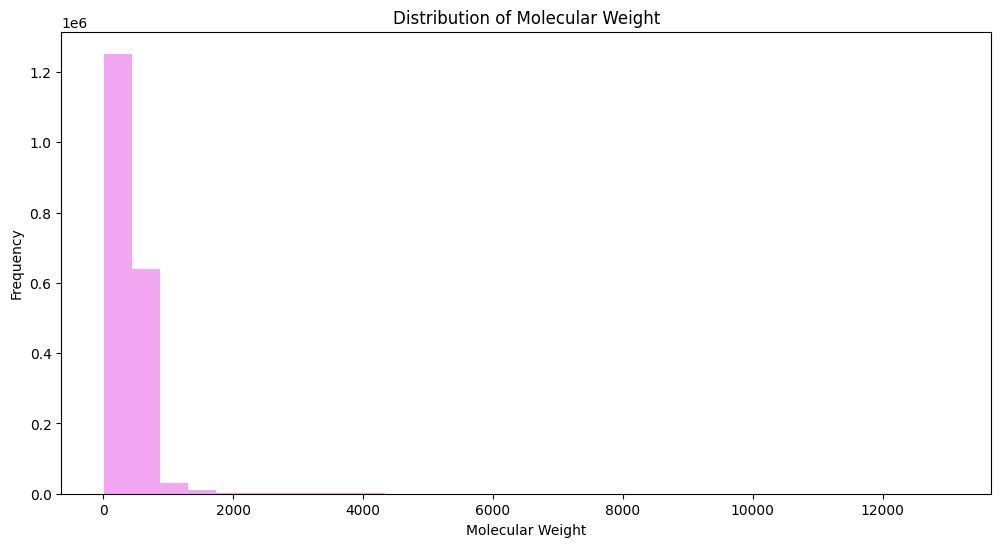

In [ ]:
# Visualize the distribution of molecular weights across chemical compounds
# Note: Molecular weight is a crucial property in drug discovery and can influence various aspects of a compound's behavior.

plt.figure(figsize=(12, 6))

# Use a more diverse color palette for the histogram
plt.hist(chembl_smiles['Molecular Weight'], bins=30, color='violet', alpha=0.7)

# Set plot attributes and labels
plt.title('Distribution of Molecular Weight')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')

# Display the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.optio

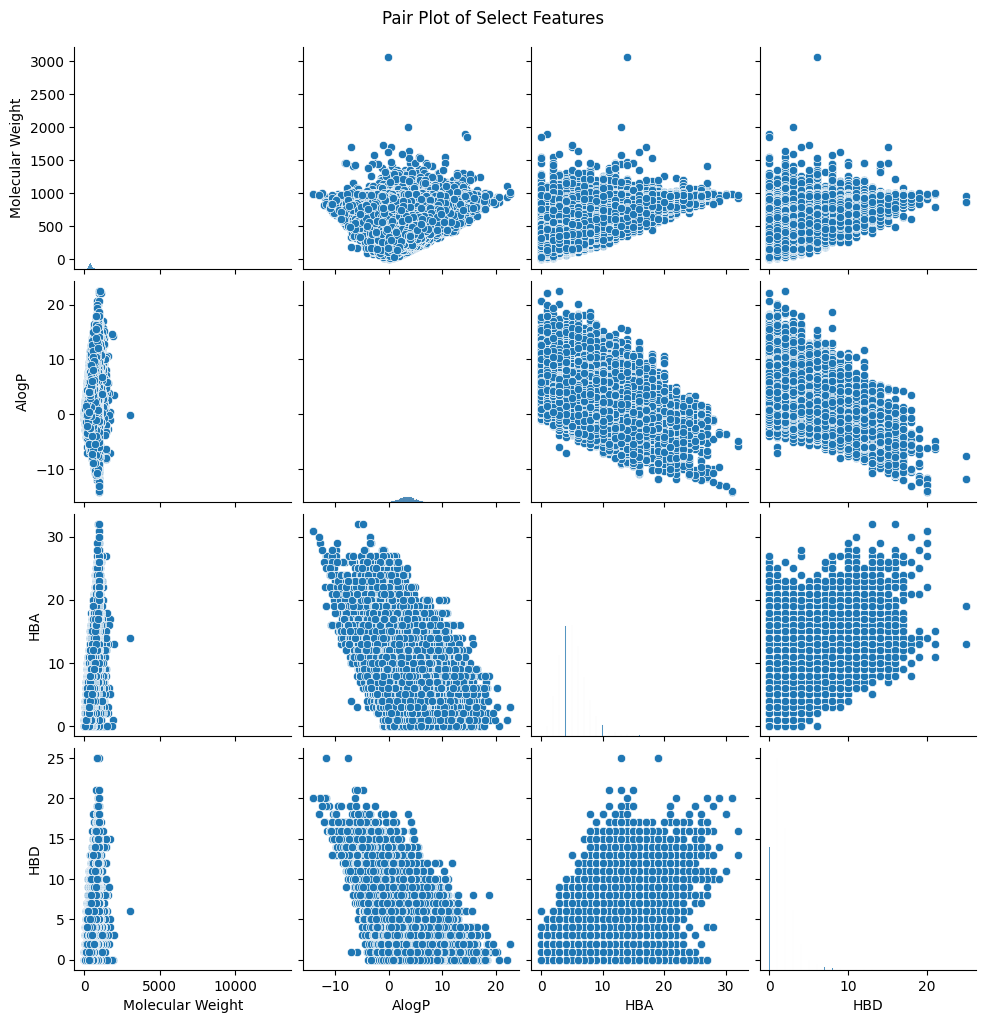

In [ ]:
import seaborn as sns

# Select specific features for pair plot analysis
selected_features = ['Molecular Weight', 'AlogP', 'HBA', 'HBD']

# Create a pair plot to visualize relationships between select features
# Note: Pair plots are useful for understanding pairwise relationships and distributions.

sns.pairplot(chembl_smiles[selected_features])

# Set the title of the pair plot
plt.suptitle('Pair Plot of Select Features', y=1.02)

# Display the pair plot
plt.show()

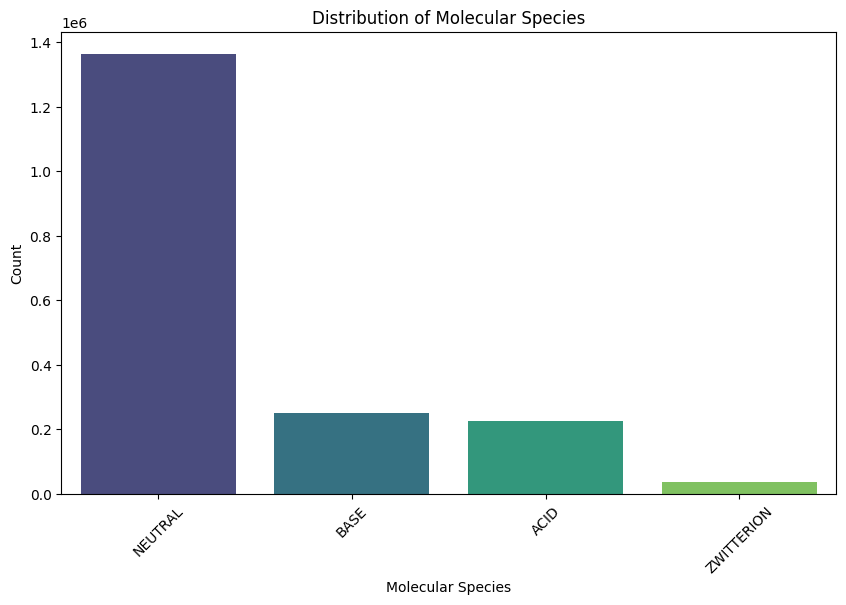

In [ ]:
# Visualize the distribution of different molecular species in the dataset
# Note: Understanding the distribution of molecular species provides insights into the diversity of compounds.

plt.figure(figsize=(10, 6))

# Use the 'viridis' color palette for better visual appeal
sns.countplot(x='Molecular Species', data=chembl_smiles, palette='viridis')

# Set plot attributes and labels
plt.title('Distribution of Molecular Species')
plt.xlabel('Molecular Species')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
# Load a dataset of drug compounds from a file into a DataFrame
# Note: The dataset is assumed to be in a file named 'dataset_cleansed.smi' and contains SMILES representations of chemical compounds.

old_smiles = pd.read_csv('../input/drug-compounds/dataset_cleansed.smi', names=["smiles"])

# Create a new column 'length' to store the length of each SMILES string
old_smiles['length'] = old_smiles["smiles"].str.len()

# Display the first few rows of the DataFrame with SMILES and corresponding lengths
old_smiles.head()

,smiles,length
0,O=C1Nc2cc(NC(=O)c3c[nH]cc(-c4ccc(C(F)(F)F)cc4)...,69
1,CC(NC(=O)Nc1cc2[nH]nc(N3CC(C(C)(C)O)C3)c2cn1)c...,53
2,N=C(N)C1CCCC(NC(=O)CN2CCCCC(NS(=O)(=O)c3ccccc3...,55
3,CCN1C(C(=O)NC(Cc2ccccc2)C(=O)C(=O)NCCCN2CCCC2=...,73
4,COCC(=O)NC1CCC(CCN2CCC(c3cccc4occc34)CC2)CC1,44


In [ ]:
# Extract the 'smiles' column from the 'moses_smiles' DataFrame
# Note: Assuming 'moses_smiles' is a DataFrame containing a 'smiles' column.

moses_smiles = moses_smiles['smiles']

# Display the shape of the extracted 'smiles' series
print("Shape before removing duplicates:", moses_smiles.shape)

# Remove duplicate SMILES strings to ensure uniqueness
moses_smiles = moses_smiles.drop_duplicates()

# Display the shape of the 'smiles' series after removing duplicates
print("Shape after removing duplicates:", moses_smiles.shape)

Shape before removing duplicates: (1584663,)
Shape after removing duplicates: (1584663,)


In [ ]:
# Extract the 'smiles' column from the 'chembl_smiles' DataFrame
# Note: Assuming 'chembl_smiles' is a DataFrame containing a 'smiles' column.

chembl_smiles = chembl_smiles['smiles']

# Display the shape of the extracted 'smiles' series
print("Shape before removing duplicates:", chembl_smiles.shape)

# Remove duplicate SMILES strings to ensure uniqueness
chembl_smiles = chembl_smiles.drop_duplicates()

# Display the shape of the 'smiles' series after removing duplicates
print("Shape after removing duplicates:", chembl_smiles.shape)

Shape before removing duplicates: (1941410,)
Shape after removing duplicates: (1941295,)


In [ ]:
# Extract the 'smiles' column from the 'old_smiles' DataFrame
# Note: Assuming 'old_smiles' is a DataFrame containing a 'smiles' column.

old_smiles = old_smiles['smiles']

# Display the shape of the extracted 'smiles' series
print("Shape before removing duplicates:", old_smiles.shape)

# Remove duplicate SMILES strings to ensure uniqueness
old_smiles = old_smiles.drop_duplicates()

# Display the shape of the 'smiles' series after removing duplicates
print("Shape after removing duplicates:", old_smiles.shape)

Shape before removing duplicates: (438552,)
Shape after removing duplicates: (438552,)


In [ ]:
import pandas as pd

# Concatenate SMILES data from different datasets (moses, chembl, and old) into a single series
# Note: Assuming 'moses_smiles', 'chembl_smiles', and 'old_smiles' are series containing SMILES strings.

smiles = pd.concat([moses_smiles, chembl_smiles])

# Display the shape of the combined SMILES series
print("Shape after combining moses and chembl:", smiles.shape)

# Remove duplicate SMILES strings to ensure uniqueness
smiles = smiles.drop_duplicates()

# Display the shape of the SMILES series after removing duplicates
print("Shape after removing duplicates:", smiles.shape)

# Append SMILES data from 'old_smiles' series to the existing combined series
smiles = pd.concat([smiles, old_smiles])

# Display the shape of the combined SMILES series after appending 'old_smiles'
print("Shape after combining with old_smiles:", smiles.shape)

# Remove duplicate SMILES strings again to ensure uniqueness
smiles = smiles.drop_duplicates()

# Display the shape of the final SMILES series after removing duplicates
print("Final shape after removing duplicates:", smiles.shape)

Shape after combining moses and chembl: (3525958,)
Shape after removing duplicates: (3470464,)
Shape after combining with old_smiles: (3909016,)
Final shape after removing duplicates: (3622395,)


In [ ]:
# Load a dataset of TRPM8 inhibitors' SMILES strings from a file into a DataFrame
# Note: Assuming the file is named 'TRPM8_inhibitors_for_fine-tune.smi' and contains SMILES representations of TRPM8 inhibitors.

trp_smiles = pd.read_csv('../input/drug-compounds/TRPM8_inhibitors_for_fine-tune.smi', names=["smiles"])

# Display the first few rows of the DataFrame to inspect the loaded data
trp_smiles.head()

,smiles
0,FC(F)(F)c1ccccc1-c1cc(C(F)(F)F)c2[nH]c(C3=NOC4...
1,O=C(Nc1ccc(OC(F)(F)F)cc1)N1CCC2(CC1)CC(O)c1ccc...
2,O=C(O)c1ccc(S(=O)(=O)N(Cc2ccc(C(F)(F)C3CC3)c(F...
3,Cc1cccc(COc2ccccc2C(=O)N(CCCN)Cc2cccs2)c1
4,CC(c1ccc(F)cc1F)N(Cc1cccc(C(=O)O)c1)C(=O)c1cc2...


In [ ]:
# Load a dataset of known TRPM8 inhibitors' SMILES strings from a file into a DataFrame
# Note: Assuming the file is named 'known_TRPM8-inhibitors.smi' and contains SMILES representations of known TRPM8 inhibitors.

k_trp_smiles = pd.read_csv('../input/drug-compounds/known_TRPM8-inhibitors.smi', names=["smiles"])

# Display the first few rows of the DataFrame to inspect the loaded data
k_trp_smiles.head()

,smiles
0,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1NC(=O)c2ccc(C)cc2
1,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1NC(=O)c2ccc(cc2)...
2,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1NC(=O)CCCCCCc2cc...
3,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1NC(=O)CCCCCCCc2c...
4,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1NC(=O)c2cccc(Cl)c2


In [ ]:
# Load a dataset of HIV inhibitors' cleaned SMILES strings from a file into a DataFrame
# Note: Assuming the file is named 'hiv_inhibitors_cleaned.smi' and contains cleaned SMILES representations of HIV inhibitors.

hiv_smiles = pd.read_csv('../input/drug-compounds/hiv_inhibitors_cleaned.smi', names=["smiles"])

# Display the first few rows of the DataFrame to inspect the loaded data
hiv_smiles.head()

,smiles
0,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1COC2OCCC12)S...
1,CC(C)(C)NC(=O)C1CC2CCCCC2CN1CC(O)C(Cc1ccccc1)N...
2,Cc1cccc(C)c1OCC(=O)NC(Cc1ccccc1)C(O)CC(Cc1cccc...
3,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1COC2OCCC12)S...
4,Cc1c(O)cccc1C(=O)NC(CSc1ccccc1)C(O)CN1CC2CCCCC...


In [ ]:
# Load a dataset of manually tested compounds' cleaned SMILES strings from a file into a DataFrame
# Note: Assuming the file is named 'manual_testing_cleaned.smi' and contains cleaned SMILES representations of manually tested compounds.

manual_t_smiles = pd.read_csv('../input/drug-compounds/manual_testing_cleaned.smi', names=["smiles"])

# Display the first few rows of the DataFrame to inspect the loaded data
manual_t_smiles.head()

,smiles
0,Cc1cc2c(cc1C)COc1ccccc1C(=O)N(c1ccccc1)CCNC(=O...
1,Cc1ccc(CC(NC(=O)C(Cc2ccccc2)NS(=O)(=O)Cc2ccccc...
2,OC1(c2cccnc2)CC2CCC(C1)N2C(c1ccccc1Cl)c1ccccc1Cl
3,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCN(C(c2ccc(-c3cccc...
4,O=C(NCC(=O)N(C(=O)NC1CCCCC1)C1CCCCC1)C(=Cc1ccc...


In [ ]:
import pandas as pd

# Assuming 'trp_smiles', 'k_trp_smiles', 'hiv_smiles', and 'manual_t_smiles' are Series containing SMILES strings.

# Concatenate SMILES data from different datasets into a single series
smiles = pd.concat([smiles, trp_smiles['smiles']], ignore_index=True)

# Remove duplicate SMILES strings to ensure uniqueness
smiles = smiles.drop_duplicates()

# Display the shape of the SMILES series after adding TRPM8 inhibitors
print("Shape after adding TRPM8 inhibitors:", smiles.shape)

# Concatenate known TRPM8 inhibitors' SMILES
smiles = pd.concat([smiles, k_trp_smiles['smiles']], ignore_index=True)

# Remove duplicate SMILES strings again to ensure uniqueness
smiles = smiles.drop_duplicates()

# Display the shape of the SMILES series after adding known TRPM8 inhibitors
print("Shape after adding known TRPM8 inhibitors:", smiles.shape)

# Concatenate HIV inhibitors' SMILES
smiles = pd.concat([smiles, hiv_smiles['smiles']], ignore_index=True)

# Remove duplicate SMILES strings again to ensure uniqueness
smiles = smiles.drop_duplicates()

# Display the shape of the SMILES series after adding HIV inhibitors
print("Shape after adding HIV inhibitors:", smiles.shape)

# Concatenate manually tested compounds' SMILES
smiles = pd.concat([smiles, manual_t_smiles['smiles']], ignore_index=True)

# Remove duplicate SMILES strings again to ensure uniqueness
smiles = smiles.drop_duplicates()

# Display the shape of the final combined SMILES series
print("Final shape after adding manually tested compounds:", smiles.shape)

Shape after adding TRPM8 inhibitors: (3622395,)
Shape after adding known TRPM8 inhibitors: (3622881,)
Shape after adding HIV inhibitors: (3622887,)
Final shape after adding manually tested compounds: (3622890,)


In [ ]:
smiles.head()

0    CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
1      CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1
2       Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO
3          Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C
4            CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O
Name: smiles, dtype: object

## SMI file

* Use the to_csv method to write the SMILES series to a file
* 'all_smiles.smi': The output file name
* header=None: Do not include column headers in the output
* index=None: Do not include row indices in the output
* sep='\t': Use tab as the delimiter between columns
* mode='a': Append mode, to add to the existing file if it already exists

In [ ]:
# Save the combined SMILES series to a file named 'all_smiles.smi'
# Note: Assuming 'smiles' is a Pandas Series containing the combined SMILES strings.

smiles.to_csv(r'all_smiles.smi', header=None, index=None, sep='\t', mode='a')

In [ ]:
# Import necessary libraries and modules
import argparse  # For parsing command line arguments
import os  # For interacting with the operating system
from tqdm import tqdm  # For displaying progress bars
from rdkit import Chem, RDLogger  # RDKit for cheminformatics
from rdkit.Chem import MolStandardize  # RDKit module for molecular standardization

# Add relevant comments explaining the purpose of each imported library or module.
# - argparse: Used for parsing command line arguments, making the script more configurable.
# - os: Allows interaction with the operating system, helpful for file and directory operations.
# - tqdm: Provides a progress bar for visualizing the progress of tasks, especially useful for loops.
# - rdkit: A powerful toolkit for cheminformatics and molecular modeling.
# - MolStandardize: A module in RDKit for standardizing molecular structures.

# Disable RDKit logger to suppress unnecessary log messages during execution
RDLogger.DisableLog('rdApp.*')

# Add any additional comments specific to the overall purpose or context of your script.

In [ ]:
class Preprocessor(object):
    def __init__(self):
        # Initialize the normalizer, largest fragment chooser, and uncharger from MolStandardize
        self.normalizer = MolStandardize.normalize.Normalizer()
        self.lfc = MolStandardize.fragment.LargestFragmentChooser()
        self.uc = MolStandardize.charge.Uncharger()

    def process(self, smi):
        # Convert SMILES to an RDKit molecule object
        mol = Chem.MolFromSmiles(smi)

        # Check if the conversion was successful
        if mol:
            # Apply normalization, choose the largest fragment, and uncharge the molecule
            mol = self.normalizer.normalize(mol)
            mol = self.lfc.choose(mol)
            mol = self.uc.uncharge(mol)

            # Convert the processed molecule back to canonical SMILES
            processed_smi = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)

            return processed_smi
        else:
            # If the conversion failed, return None
            return None

## Preprocessor

* The `Preprocessor` class in the provided code is crafted to improve the quality and uniformity of molecular data expressed in SMILES notation.

* This objective is accomplished through a sequence of processing steps leveraging the RDKit library and the MolStandardize module. Within the class, three MolStandardize components are initialized: the `Normalizer`, which standardizes variations in chemical representations such as tautomeric forms and stereochemistry; the `LargestFragmentChooser`, which prioritizes the selection of the largest fragment in a molecule, focusing on its principal structural component; and the `Uncharger`, which eliminates formal charges to simplify the representation and ensure the neutrality of molecules. The `process` method accepts a SMILES string, converts it into an RDKit molecule object, and, upon successful conversion, applies normalization, selects the largest fragment, and removes charges from the molecule. The processed molecule is then transformed back into canonical SMILES for a consistent representation.

* In instances where the initial conversion encounters an issue, the method returns `None`.

* In summary, the `Preprocessor` class plays a crucial role in standardizing and preprocessing molecular structures, establishing a dependable and refined basis for subsequent analyses or modeling tasks.

In [ ]:
# Set the input file path containing SMILES strings
input_file = "./all_smiles.smi"

# Initialize a Preprocessor instance
pp = Preprocessor()

# Read SMILES strings from the input file
with open(input_file, 'r') as f:
    smiles = [l.rstrip() for l in f]

# Print the number of input SMILES
print(f'Input SMILES num: {len(smiles)}')

# Print a message indicating the start of the cleanup process
print('Start to clean up')

# Process SMILES using the Preprocessor
pp_smiles = [pp.process(smi) for smi in tqdm(smiles)]
print('Step 1 / 3 completed')

# Remove duplicates and filter out invalid SMILES
cl_smiles = list(set([s for s in pp_smiles if s]))
print('Step 2 / 3 completed')

# Initialize a SmilesTokenizer instance
print('Initiating tokenizer')
st = SmilesTokenizer()
print('Tokenizer initiated')

# Print a message indicating the start of the tokenization process
print('In finetune kwargs')

# Print the total number of SMILES after cleanup
total = len(cl_smiles)
print(total)

# Initialize counters
count = 0
skip_count = 0
timeout_count = 0
out_smiles = []

# Iterate through cleaned SMILES and tokenize them
for cl_smi in cl_smiles:
    try:
        # Tokenize the cleaned SMILES
        tokenized_smi = st.tokenize(cl_smi)

        # Filter based on tokenized length criteria
        if tokenized_smi == []:
            timeout_count += 1
        elif 34 <= len(tokenized_smi) <= 128:
            out_smiles.append(cl_smi)
    except:
        # Handle exceptions (e.g., timeout) and increment skip_count
        skip_count += 1

    # Increment the total count
    count += 1

    # Print progress every 25,000 iterations
    if count % 25000 == 0:
        print(count, ' completed out of ', total, '. Skipped ', skip_count, '. Timed out ', timeout_count)

# Print a completion message
print('Done.')

# Print the number of output SMILES after tokenization
print(f'Output SMILES num: {len(out_smiles)}')

Input SMILES num: 3622890
Start to clean up


 22%|██▏       | 782620/3622890 [16:11<58:40, 806.81it/s]  Gave up normalization after 200 restarts
Gave up normalization after 200 restarts
Gave up normalization after 200 restarts
100%|██████████| 3622890/3622890 [1:27:11<00:00, 692.49it/s]


Step 1 / 3 completed
Step 2 / 3 completed
Initiating tokenizer
Tokenizer initiated
In finetune kwargs
3282058
25000  completed out of  3282058 . Skipped  0 . Timed out  0
50000  completed out of  3282058 . Skipped  0 . Timed out  0
75000  completed out of  3282058 . Skipped  0 . Timed out  0
100000  completed out of  3282058 . Skipped  0 . Timed out  0
125000  completed out of  3282058 . Skipped  0 . Timed out  0
150000  completed out of  3282058 . Skipped  0 . Timed out  0
175000  completed out of  3282058 . Skipped  0 . Timed out  0
200000  completed out of  3282058 . Skipped  0 . Timed out  0
225000  completed out of  3282058 . Skipped  0 . Timed out  0
250000  completed out of  3282058 . Skipped  0 . Timed out  0
275000  completed out of  3282058 . Skipped  0 . Timed out  0
300000  completed out of  3282058 . Skipped  0 . Timed out  0
325000  completed out of  3282058 . Skipped  0 . Timed out  0
350000  completed out of  3282058 . Skipped  0 . Timed out  0
375000  completed out of 

In [ ]:
# Set the output file path for cleaned and tokenized SMILES
output_file = "cleaned.smi"

# Save the cleaned and tokenized SMILES to the output file
with open(output_file, 'w') as f:
    for smi in out_smiles:
        f.write(smi + '\n')

# Print a message indicating the completion of saving to the output file
print(f'Cleaned and tokenized SMILES saved to {output_file}')

Cleaned and tokenized SMILES saved to cleaned.smi
